## **1. Import Library**

In [11]:
# Library for Dataset Preparation, Processing, and Visualization
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn

# Library for Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier

# Pickle
import pickle

# Testing and Cross Validation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold



## **2. Import Dataset**

Semua dataset yang digunakan dapat diunduh [disini](https://drive.google.com/drive/folders/1arQb-Z-5PSMG1JAR_-dvyq0xpnZZAFKe?usp=sharing)

### **1.   Train Dataset (train_preprocesses.tsv)**

  Dataset yang berisi kumpulan teks tweet yang sudah dilabeli untuk keperluan pembentukan model machine learning serta validasi. Label yang digunakan adalah 'positive', 'negative', dan 'neutral'.

In [12]:
df_train = pd.read_csv('dataset/train_preprocess.tsv', sep='\t', names=['text', 'label'])
df_train.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


### **2.   Test Dataset (data.csv)**

  Dataset yang berisi kumpulan teks tweet yang belum dilabeli untuk menguji model machine learning yang telah dibuat.

In [13]:
df_test = pd.read_csv('dataset/data.csv', encoding='latin-1')
df_test = df_test[['Tweet']]
df_test = df_test.rename(columns = {'Tweet' :'text'})
df_test['text'].astype(str)
df_test.head()

,text
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


### **3.   Slangword Dataset (combined_slang_words.json)**

  Dataset yang berisi kumpulan kata yang tidak baku (slang) yang sudah dipasangkan dengan kata bakunya (normal). Dataset ini digunakan untuk menormalisasi teks pada Tweet.

In [14]:
with open('dataset/combined_slang_words.json') as f:
    jsonstr = json.load(f)
df_slang = pd.DataFrame(list(jsonstr.items()),columns = ['slang','normal']) 

df_slang.head()

,slang,normal
0,@,di
1,abis,habis
2,ad,ada
3,adlh,adalah
4,afaik,as far as i know


### **4.   Stopword Dataset (combined_stop_words.csv)**

  Dataset yang berisi stopwords yng merupakan kumpulan kata umum yang sering dipakai dalam kalimat, namun tidak memiliki makna yang signifikan. Dataset ini digunakan untuk menghilangkan stopwords pada Tweet.

In [15]:
df_stop = pd.read_csv('dataset/combined_stop_words.csv', encoding = 'latin-1', header = None)
df_stop.head()

,0
0,adalah
1,adapun
2,agaknya
3,akan
4,akhir


## **3. Data Pre-Processing**

### **1. Null Values**

In [16]:
print('-------------------------------')
print('Training dataset Null Values :')
print(df_train.isnull().sum())
print('-------------------------------')

print('Test dataset Null Values :')
print(df_test.isnull().sum())
print('-------------------------------')

-------------------------------
Training dataset Null Values :
text     0
label    0
dtype: int64
-------------------------------
Test dataset Null Values :
text    0
dtype: int64
-------------------------------


Tidak ada null values baik pada training dataset maupun pada test dataset

### **2. Duplicated Values**

In [17]:
print('Training dataset duplicated Values :', df_train.duplicated().sum())
print()
print('Test dataset duplicated Values :', df_test.duplicated().sum())

Training dataset duplicated Values : 67

Test dataset duplicated Values : 146


Duplicated value dalam dataset perlu dibuang terlebih dahulu

In [18]:
df_train.drop_duplicates(inplace = True, ignore_index= True)
print('Jumlah Duplicated Values pada Training Dataset setelah dibersihkan :', df_train.duplicated().sum())

print()

df_test.drop_duplicates(inplace = True, ignore_index = True)
print('Jumlah Duplicated Values pada Test Dataset setelah dibersihkan :', df_test.duplicated().sum())


Jumlah Duplicated Values pada Training Dataset setelah dibersihkan : 0

Jumlah Duplicated Values pada Test Dataset setelah dibersihkan : 0


### **3. Data Cleansing (Regrex, Slangwords, Stopwords)**

Untuk mempermudah cleansing, maka dibuat satu fungsi yang dapat melakukan text cleansing terhadap tweet pada kolom teks, yaitu sebagai berikut:

In [19]:
def Cleansing(text):
    
    # Regrex
    text = text.lower() # membuat semua huruf menjadi lowercase
    text = text.strip() # menghapus spasi pada awal dan akhir kalimat
    text = re.sub('\n', ' ', text) # menghilangkan new line
    text = re.sub('x[a-z0-9]{,2}',' ', text) # menghilangkan rawstring emoji
    text = re.sub('user', ' ', text) # menghilangkan mention USER tertentu
    text = re.sub('url', ' ', text) # menghilangkan teks 'url' pada teks
    text = re.sub('http\S+', '', text) # menghilangkan url
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) # menghilangkan non-alpha numerik
    text = re.sub('( rt )|(rt )', ' ', text) # menghilangkan retweet
    text = re.sub('  +', ' ', text) # Menghilangkan spasi berlebih

    # Slangwords Normalization
    Slang_dict = dict(zip(df_slang['slang'], df_slang['normal']))  # Membuat dataframe slang menjadi dict
    holder = [] # variabel list untuk menyimpan kata slang yang sudah dinormalkan
    
    #pengulangan untuk mengubah word slang menjadi word yang sesuai pada dict
    for word in text.split(' '): 
        
        if word in Slang_dict.keys(): 
            word = Slang_dict[word] # mengubah kata slang menjadi kata yang sesuai pada dict
            holder.append(word) # simpan kata slang yang sudah normal ke variabel holder
        else :
            holder.append(word) 
            
    text = ' '.join(holder) # mengembalikan satu kalimat yang sudah digabungkan dari list huruf pada holder

    # Stopwords Removal
    holder = []
      
    for words in text.split(' '):
        if words in df_stop[0].values:
          holder.append(' ')
        else:
          holder.append(words)

    text = ' '.join(holder)
    text = re.sub(' +', ' ', text) # menghilangkan spasi berlebih
    text = text.strip() # menghilangkan whitespace pada awal dan akhir string

    return text
    

Fungsi yang telah dibuat kemudian dapat digunakan pada dataset train dan test :

In [20]:
df_train['text_clean'] = df_train['text'].apply(lambda x : Cleansing(x))
df_train.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nyaman...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unbo g paket barang bagus menet...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


In [21]:
df_test['text_clean'] = df_test['text'].apply(lambda x : Cleansing(x))
df_test.head()

,text,text_clean
0,- disaat semua cowok berusaha melacak perhatia...,disaat cowok berusaha melacak perhatian lantas...
1,RT USER: USER siapa yang telat ngasih tau elu?...,terlambat edan sarap bergaul ciga jifla calis ...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang berfikir percaya tuhan jatuh berkali...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,nku matamu sipit diliat
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kapir dongoknya awal dongok hahahah


## **4. Visualization**

Pie Chart dapat digunakan untuk melihat proporsi dari masing-masing label pada Training Dataset

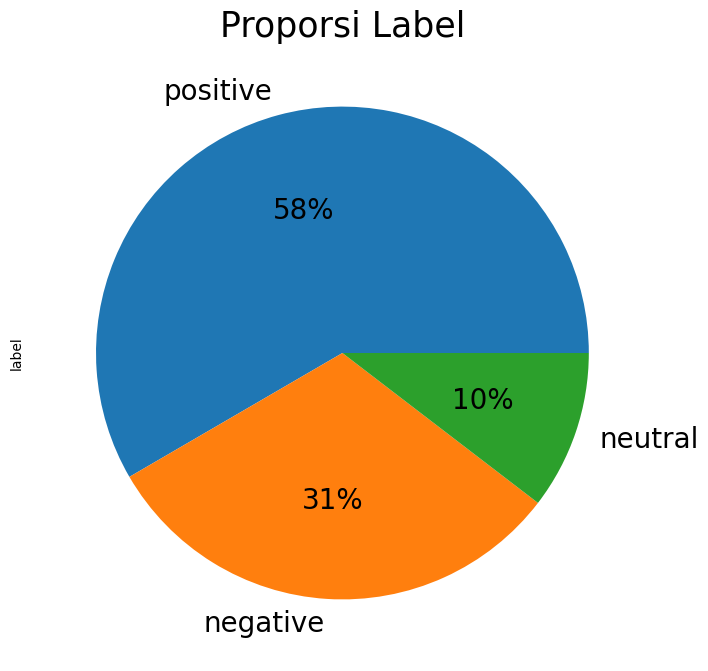

In [22]:
df_train['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(8,8), fontsize=20)
plt.title('Proporsi Label', fontsize=25)
plt.show()

Persebaran jumlah karakter dan kata kemudian dapat divisualisasikan menggunakan histogram

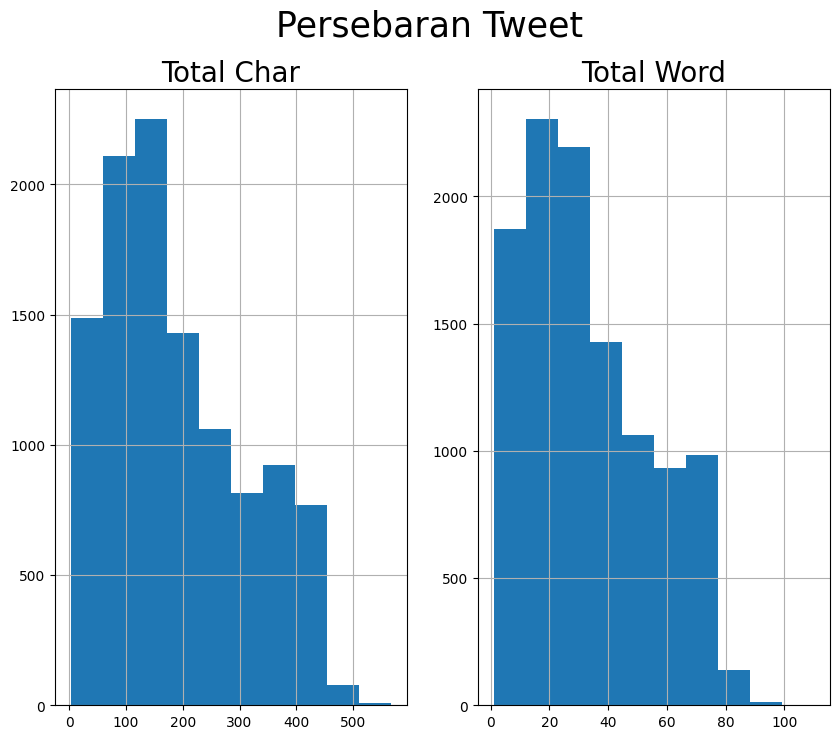

In [23]:
# Membuat kolom total char
df_train['total char'] = df_train['text'].apply(lambda x : len(x))

# Membuat kolom total word
df_train['total word'] = df_train['text'].apply(lambda x : len(x.split()))

# Histogram Total Char and Total Word
fig, ax = plt.subplots(1,2, figsize=(10,8))
fig.suptitle('Persebaran Tweet', fontsize= 25)


df_train['total char'].hist(ax = ax[0])
ax[0].set_title('Total Char', fontsize= 20)
df_train['total word'].hist(ax = ax[1])
ax[1].set_title('Total Word', fontsize= 20)

plt.show()

## **5. Feature Extraction**

Untuk mempermudah penulisan kode, maka data teks dan label disimpan dalam variabel 

In [24]:
data_preprocessed = df_train['text_clean'].tolist()
classes = df_train['label']

In [25]:
cv = CountVectorizer()
cv.fit(data_preprocessed)

X_cv = cv.transform(data_preprocessed)
X_cv

<10933x16436 sparse matrix of type '<class 'numpy.int64'>'
	with 153031 stored elements in Compressed Sparse Row format>

In [26]:
pickle.dump(cv, open("pickle/feature_cv.pkl", "wb"))

## **6. Splitting the Dataset into Train and Test**

Feature (X) dan label (y) akan dibagi menjadi train dan test. Feature yang digunakan dapat dipilih dari hasil Bag of Word (X_cv) maupun TF-IDF (X_tf).

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, classes, test_size = 0.2)

## **7. Model Training and Evaluation**

In [28]:
# Training
model_neural = MLPClassifier(hidden_layer_sizes=(64,),max_iter=300,activation='relu',solver='adam',learning_rate_init=0.001, early_stopping=True, n_iter_no_change=20)
model_neural.fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(64,), max_iter=300,
              n_iter_no_change=20)

In [29]:
# Load the Training Model with Pickle
pickle.dump(model_neural, open("pickle/model_neural.pkl", "wb"))

In [30]:
# Classification Report
test = model_neural.predict(X_test)
print ("Testing selesai")

print(classification_report(y_test, test)) 

Testing selesai
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80       684
     neutral       0.85      0.65      0.74       220
    positive       0.91      0.92      0.91      1283

    accuracy                           0.86      2187
   macro avg       0.85      0.80      0.82      2187
weighted avg       0.86      0.86      0.86      2187



In [31]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

X = X_cv
y = classes

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X_cv[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    clf = MLPClassifier(hidden_layer_sizes=(64,),max_iter=1000,activation='relu',solver='adam',learning_rate_init=0.001,early_stopping=True,n_iter_no_change=20)
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)
 
    accuracy = accuracy_score(target_test,preds)

    print("Training ke-", iteration)
    print(classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)

# Accuracy Average
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

    negative       0.78      0.81      0.80       690
     neutral       0.80      0.66      0.72       220
    positive       0.90      0.91      0.90      1277

    accuracy                           0.85      2187
   macro avg       0.83      0.79      0.81      2187
weighted avg       0.85      0.85      0.85      2187

Training ke- 2
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80       667
     neutral       0.82      0.63      0.71       219
    positive       0.91      0.92      0.91      1301

    accuracy                           0.86      2187
   macro avg       0.84      0.79      0.81      2187
weighted avg       0.86      0.86      0.86      2187

Training ke- 3
              precision    recall  f1-score   support

    negative       0.78      0.81      0.80       695
     neutral       0.83      0.60      0.70       213
    positive       0.89      0

## **8. Predict**

In [32]:
# Feature Extraction for Test Data
data_preprocessed_test = df_test['text_clean'].tolist()
X_cv_test = cv.transform(data_preprocessed_test) 

# Predict the label for Test Data
predict_test = model_neural.predict(X_cv_test)

# Convert the Label Prediction to Dataframe
df_label = pd.DataFrame(predict_test, columns=['label'])

# Join the Label Prediction to original Test Dataframe
df_output = pd.concat([df_test,df_label], axis = 1) # Original Test Dataframe (Before Cleaning) + Label
df_output

,text,text_clean,label
0,- disaat semua cowok berusaha melacak perhatia...,disaat cowok berusaha melacak perhatian lantas...,positive
1,RT USER: USER siapa yang telat ngasih tau elu?...,terlambat edan sarap bergaul ciga jifla calis ...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang berfikir percaya tuhan jatuh berkali...,positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,nku matamu sipit diliat,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kapir dongoknya awal dongok hahahah,negative
...,...,...,...
13018,USER jangan asal ngomong ndasmu. congor lu yg ...,bicara ndasmu mulut sekate2 anjyng,negative
13019,USER Kasur mana enak kunyuk',kasur enak kunyuk,negative
13020,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,hati hati bisu g nlagi bosan mengeluh,negative
13021,USER USER USER USER Bom yang real mudah terdet...,bom real mudah terdeteksi bom terkubur dahsyat...,negative


In [34]:
df_output.to_csv('output_nn.csv', index = False)

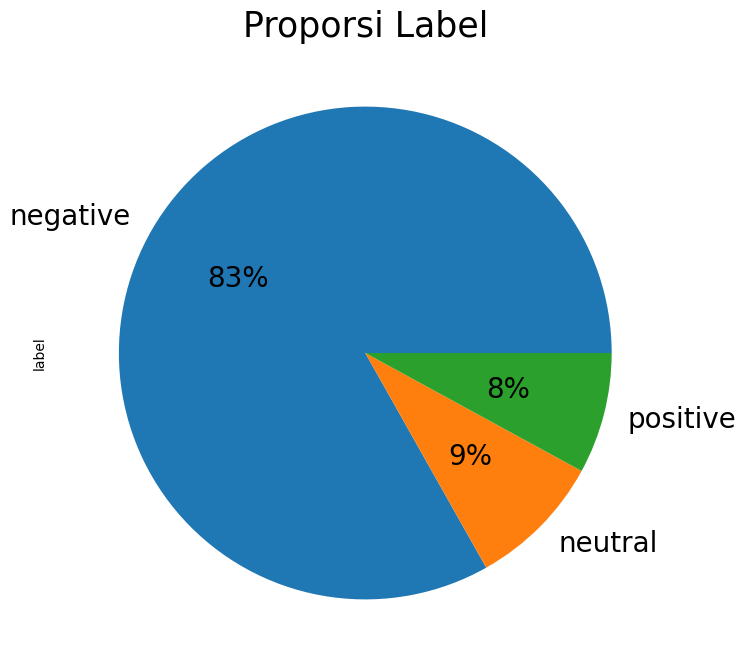

In [33]:
# Pie Chart for Label Distribution Overview

df_output['label'].value_counts().plot(kind='pie', autopct='%1.00f%%', figsize=(8,8), fontsize = 20)
plt.title('Proporsi Label', fontsize=25)
plt.show()